# 结果可视化

### AGS U-Net Meta

In [99]:
import torch

# 加载保存的张量
prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Gaussian/outputs.pth')

# 将小于0.1的值设置为0
prediction[prediction < 0.1] = 0

# 如果需要，保存修改后的张量
torch.save(prediction, '/root/autodl-tmp/competition/cpt/FURENet_Gaussian/processed_outputs.pth')



In [9]:
import torch

# 加载保存的张量
ground_truth = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Gaussian/labels.pth')
prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Gaussian/processed_outputs.pth')


In [10]:
print(ground_truth.shape)
print(prediction.shape)

torch.Size([100, 10, 256, 256])
torch.Size([100, 10, 256, 256])


In [11]:
prediction[0][0].shape

torch.Size([256, 256])

In [12]:
import numpy as np

# 将torch.Tensor转换为numpy数组
prediction_numpy = prediction[0][0].cpu().numpy()

# 保存numpy数组到CSV文件
# np.savetxt('prediction.csv', prediction_numpy, delimiter=',')


In [13]:
def denormalize(tensor, norm_param):
    mmin, mmax = norm_param
    denormalized_tensor = tensor * (mmax - mmin) + mmin
    return denormalized_tensor

# 反归一化
norm_param_dbz = [0, 65]  # 以dBZ为例
ground_truth_denorm = denormalize(ground_truth, norm_param_dbz)
prediction_denorm = denormalize(prediction, norm_param_dbz)

# 计算评估指标
error = torch.abs(ground_truth_denorm - prediction_denorm).mean()


In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# 将张量转换为 NumPy 数组
ground_truth_np = ground_truth_denorm.cpu().numpy()
prediction_np = prediction_denorm.cpu().numpy()

# 计算每个样本的 MAE
mae_per_sample = np.mean(np.abs(ground_truth_np - prediction_np), axis=(1,2,3))

# 计算总的 MAE
total_mae = np.mean(mae_per_sample)

print(f'Total MAE: {total_mae}')


Total MAE: 1.7062028646469116


In [18]:
## 计算CSI
import torch
ground_truth_np = ground_truth_denorm.cpu().numpy()
prediction_np = prediction_denorm.cpu().numpy()

# 设定阈值
threshold = 30

# 将数据转换为二进制（强对流为1，非强对流为0）
ground_truth_bin = (ground_truth_np >= threshold).astype(float)
prediction_bin = (prediction_np >= threshold).astype(float)

# 计算 Hits, Misses, 和 False Alarms
hits = np.sum(ground_truth_bin * prediction_bin)
misses = np.sum(ground_truth_bin * (1 - prediction_bin))
false_alarms = np.sum((1 - ground_truth_bin) * prediction_bin)

# 计算 CSI
csi = hits / (hits + misses + false_alarms)
# csi = csi.item()  # 转换为Python标量

print(f'CSI: {csi:.2f}')


CSI: 0.41


In [19]:
# 计算召回率
recall = hits / (hits + misses)

print(f'Recall: {recall:.2f}')


Recall: 0.46


In [20]:
# 计算精确度
precision = hits / (hits + false_alarms)

print(f'Precision: {precision:.2f}')


Precision: 0.77


In [21]:
# 用前面计算的精确度和召回率来计算F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'F1 Score: {f1_score:.2f}')


F1 Score: 0.58


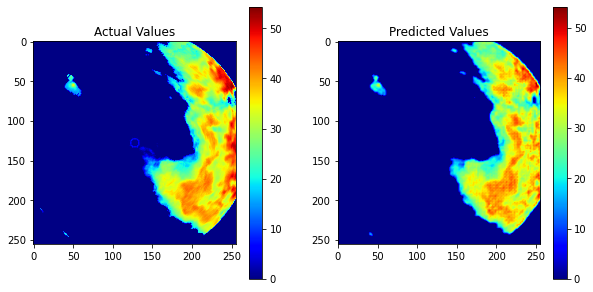

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

# 创建自定义颜色映射
colors = [(cm.jet(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
ground_truth_sample = ground_truth_np[sample_idx]
prediction_sample = prediction_np[sample_idx]

# 选择一个通道/时间步
channel_idx = 0  # 选择第一个通道/时间步，你可以更改此索引以查看其他通道/时间步
ground_truth_channel = ground_truth_sample[channel_idx]
prediction_channel = prediction_sample[channel_idx]

# 绘制实际值和预测值
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_channel, cmap=new_map, origin='upper')
plt.title('Actual Values')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(prediction_channel, cmap=new_map, origin='upper')
plt.title('Predicted Values')
plt.colorbar()

plt.show()


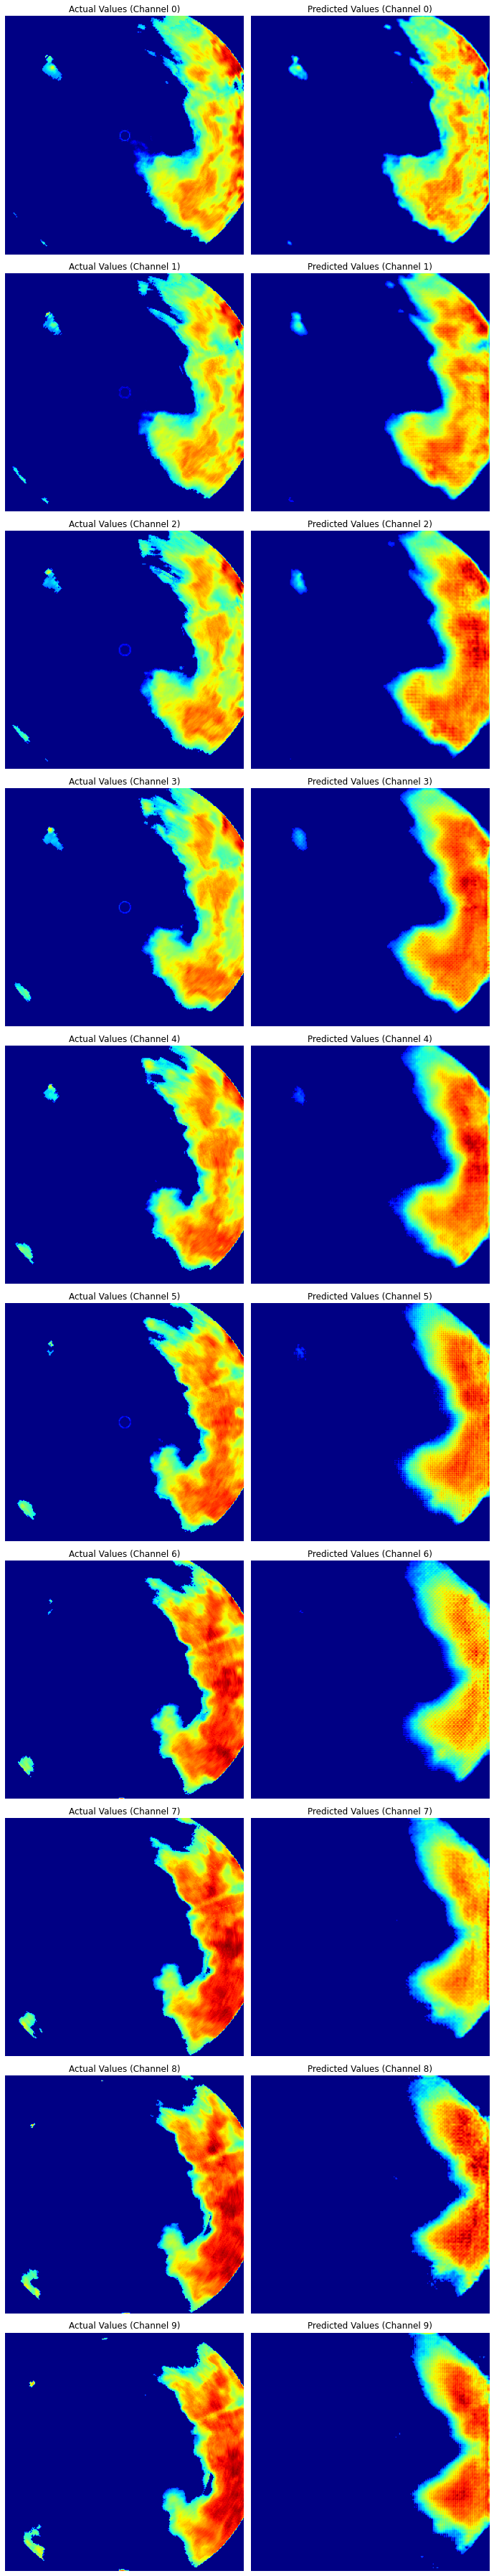

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

# 创建自定义颜色映射
# colors = [(1, 1, 1)] + [(cm.Blues(i)) for i in range(1, 256)]
# new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
colors = [(cm.jet(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
# sample_idx = 0
ground_truth_sample = ground_truth_np[sample_idx]
prediction_sample = prediction_np[sample_idx]

# 获取通道/时间步的数量
num_channels = ground_truth_sample.shape[0]

# 创建一个大图，其中每个通道/时间步都有自己的子图
fig, axs = plt.subplots(num_channels, 2, figsize=(10, 5 * num_channels))

for channel_idx in range(num_channels):
    ground_truth_channel = ground_truth_sample[channel_idx]
    prediction_channel = prediction_sample[channel_idx]
    
    # 左列显示真实值
    axs[channel_idx, 0].imshow(ground_truth_channel, cmap=new_map, origin='upper')
    axs[channel_idx, 0].set_title(f'Actual Values (Channel {channel_idx})')
    axs[channel_idx, 0].axis('off')
    
    # 右列显示预测值
    axs[channel_idx, 1].imshow(prediction_channel, cmap=new_map, origin='upper')
    axs[channel_idx, 1].set_title(f'Predicted Values (Channel {channel_idx})')
    axs[channel_idx, 1].axis('off')

# 调整子图之间的间距
plt.tight_layout()
plt.show()


## FURENet

In [44]:
import torch

# 加载保存的张量
prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Raw/outputs.pth')

# 将小于0.1的值设置为0
prediction[prediction < 0.1] = 0

# 如果需要，保存修改后的张量
torch.save(prediction, '/root/autodl-tmp/competition/cpt/FURENet_Raw/processed_outputs.pth')



In [24]:
import torch

# 加载保存的张量
ground_truth = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Raw/labels.pth')
prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Raw/processed_outputs.pth')

In [25]:
def denormalize(tensor, norm_param):
    mmin, mmax = norm_param
    denormalized_tensor = tensor * (mmax - mmin) + mmin
    return denormalized_tensor

# 反归一化
norm_param_dbz = [0, 65]  # 以dBZ为例
ground_truth_denorm = denormalize(ground_truth, norm_param_dbz)
prediction_denorm = denormalize(prediction, norm_param_dbz)

# 计算评估指标
error = torch.abs(ground_truth_denorm - prediction_denorm).mean()

In [26]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# 将张量转换为 NumPy 数组
ground_truth_np = ground_truth_denorm.cpu().numpy()
prediction_np = prediction_denorm.cpu().numpy()

# 计算每个样本的 MAE
mae_per_sample = np.mean(np.abs(ground_truth_np - prediction_np), axis=(1,2,3))

# 计算总的 MAE
total_mae = np.mean(mae_per_sample)

print(f'Total MAE: {total_mae}')

Total MAE: 1.791501522064209


In [28]:
## 计算CSI
import torch

# 设定阈值
threshold = 30

# 将数据转换为二进制（强对流为1，非强对流为0）
ground_truth_bin = (ground_truth_np >= threshold).astype(float)
prediction_bin = (prediction_np >= threshold).astype(float)

# 计算 Hits, Misses, 和 False Alarms
hits = np.sum(ground_truth_bin * prediction_bin)
misses = np.sum(ground_truth_bin * (1 - prediction_bin))
false_alarms = np.sum((1 - ground_truth_bin) * prediction_bin)

# 计算 CSI
csi = hits / (hits + misses + false_alarms)
# csi = csi.item()  # 转换为Python标量

print(f'CSI: {csi:.2f}')


CSI: 0.32


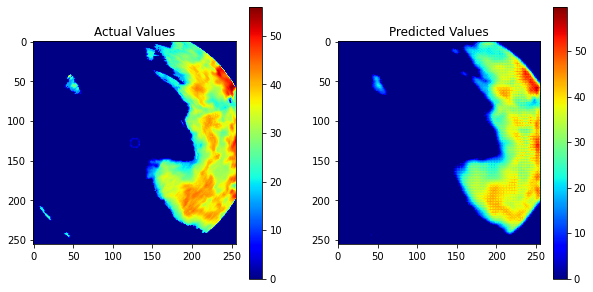

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

# 创建自定义颜色映射
# colors = [(1, 1, 1)] + [(cm.Blues(i)) for i in range(1, 256)]
# new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
colors = [(cm.jet(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
ground_truth_sample = ground_truth_np[sample_idx]
prediction_sample = prediction_np[sample_idx]

# 选择一个通道/时间步
channel_idx = 1  # 选择第一个通道/时间步，你可以更改此索引以查看其他通道/时间步
ground_truth_channel = ground_truth_sample[channel_idx]
prediction_channel = prediction_sample[channel_idx]

# 绘制实际值和预测值
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_channel, cmap=new_map, origin='upper')
plt.title('Actual Values')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(prediction_channel, cmap=new_map, origin='upper')
plt.title('Predicted Values')
plt.colorbar()

plt.show()


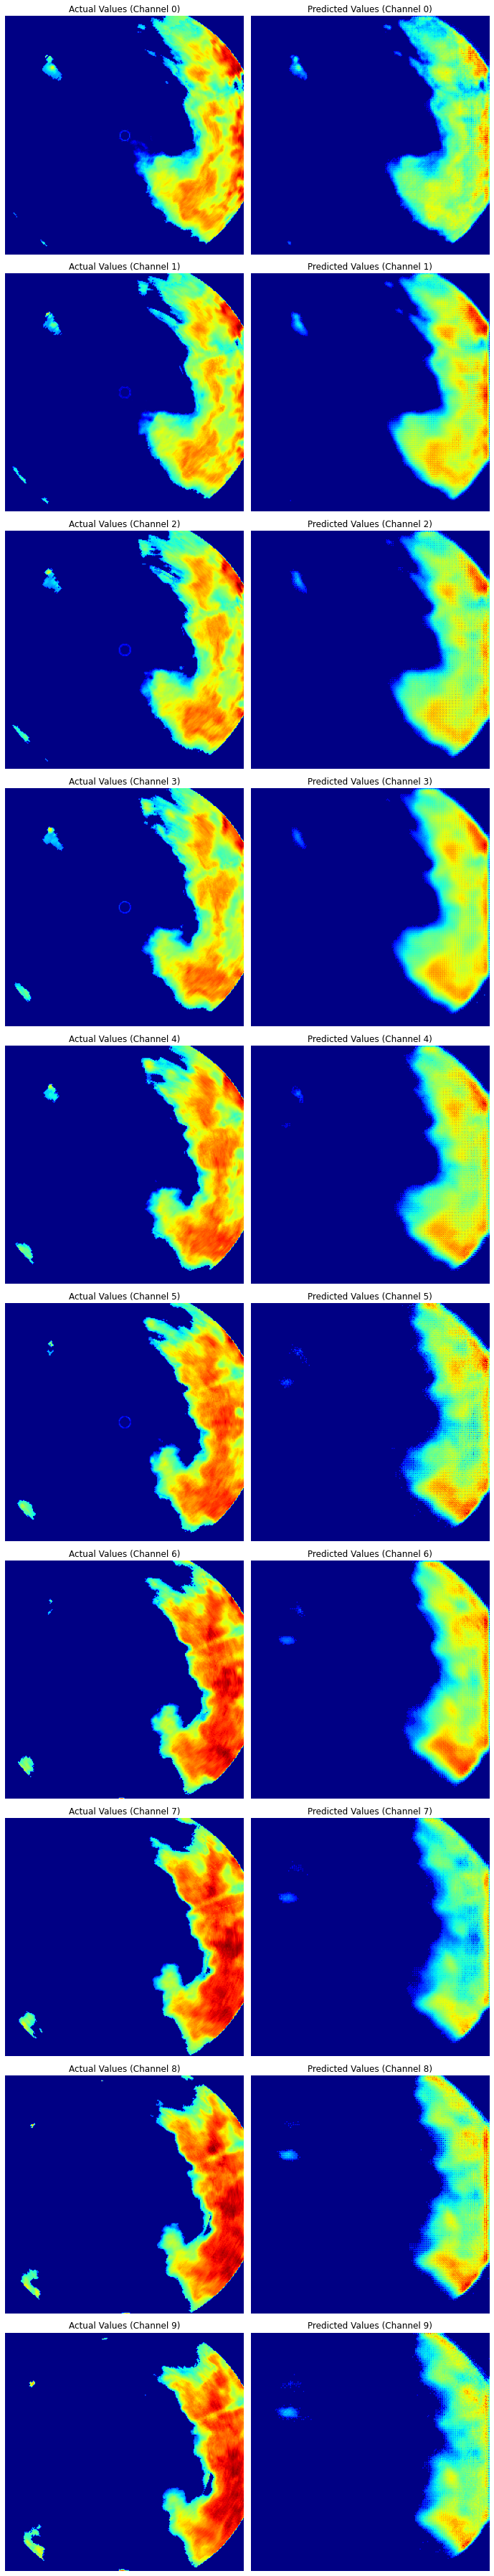

In [95]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

# 创建自定义颜色映射
colors = [(cm.jet(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
# sample_idx = 0
ground_truth_sample = ground_truth_np[sample_idx]
prediction_sample = prediction_np[sample_idx]

# 获取通道/时间步的数量
num_channels = ground_truth_sample.shape[0]

# 创建一个大图，其中每个通道/时间步都有自己的子图
fig, axs = plt.subplots(num_channels, 2, figsize=(10, 5 * num_channels))

for channel_idx in range(num_channels):
    ground_truth_channel = ground_truth_sample[channel_idx]
    prediction_channel = prediction_sample[channel_idx]
    
    # 左列显示真实值
    axs[channel_idx, 0].imshow(ground_truth_channel, cmap=new_map, origin='upper')
    axs[channel_idx, 0].set_title(f'Actual Values (Channel {channel_idx})')
    axs[channel_idx, 0].axis('off')
    
    # 右列显示预测值
    axs[channel_idx, 1].imshow(prediction_channel, cmap=new_map, origin='upper')
    axs[channel_idx, 1].set_title(f'Predicted Values (Channel {channel_idx})')
    axs[channel_idx, 1].axis('off')

# 调整子图之间的间距
plt.tight_layout()
plt.show()


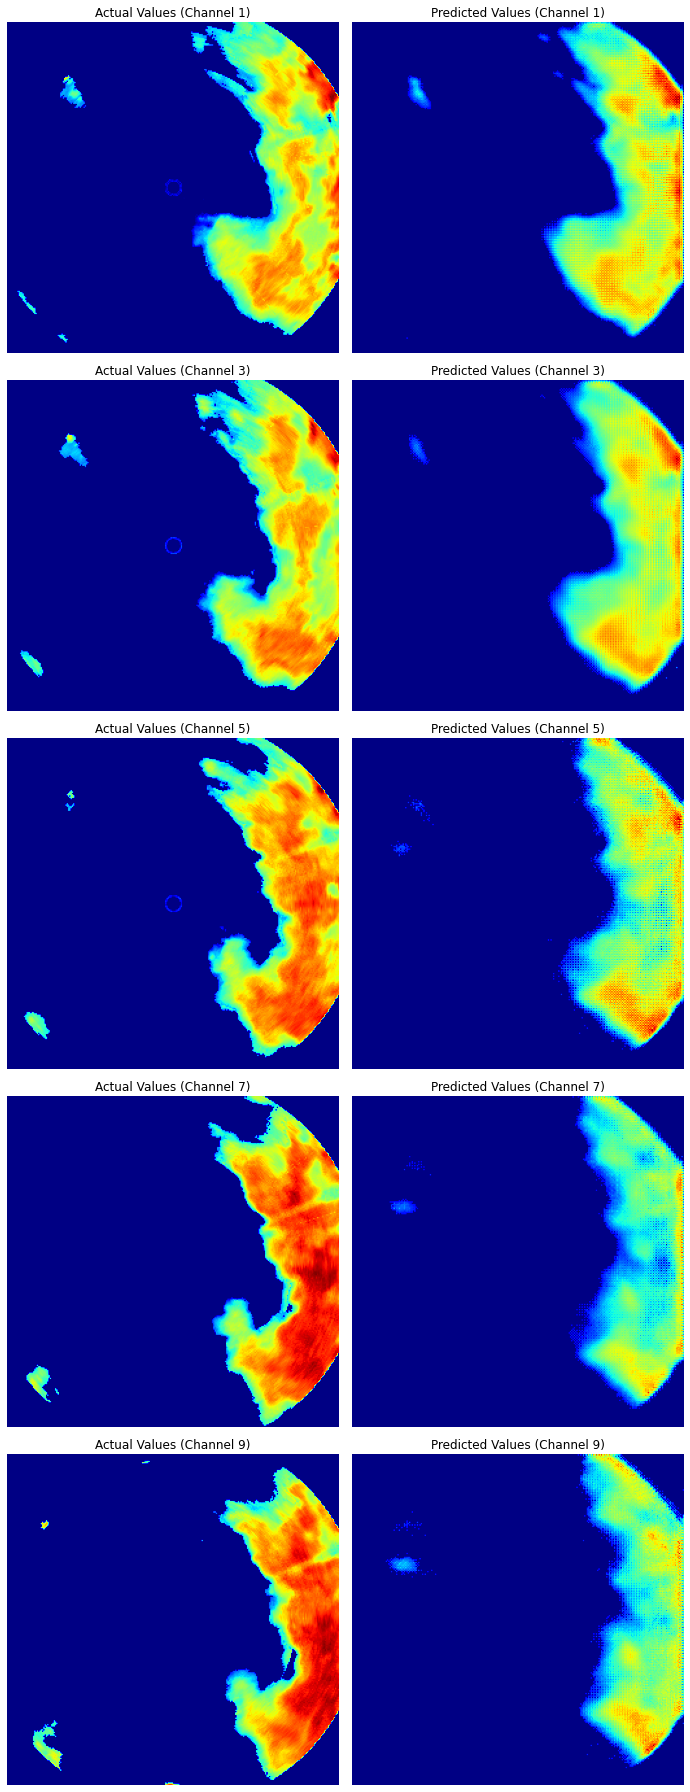

In [98]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

# 创建自定义颜色映射
colors = [(cm.jet(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
ground_truth_sample = ground_truth_np[sample_idx]
prediction_sample = prediction_np[sample_idx]

# 获取通道/时间步的数量
num_channels = ground_truth_sample.shape[0]

# 定义要显示的行
display_rows = [1, 3, 5, 7, 9]  # 对应于第2、4、6、8和10行

# 创建一个新的figure对象
fig = plt.figure(figsize=(10, 5 * len(display_rows)))

for i, channel_idx in enumerate(display_rows):
    ground_truth_channel = ground_truth_sample[channel_idx]
    prediction_channel = prediction_sample[channel_idx]
    
    # 为真实值创建子图
    ax_gt = fig.add_subplot(len(display_rows), 2, i*2 + 1)
    ax_gt.imshow(ground_truth_channel, cmap=new_map, origin='upper')
    ax_gt.set_title(f'Actual Values (Channel {channel_idx})')
    ax_gt.axis('off')
    
    # 为预测值创建子图
    ax_pred = fig.add_subplot(len(display_rows), 2, i*2 + 2)
    ax_pred.imshow(prediction_channel, cmap=new_map, origin='upper')
    ax_pred.set_title(f'Predicted Values (Channel {channel_idx})')
    ax_pred.axis('off')

# 调整子图之间的间距
plt.tight_layout()
plt.show()


## 合集图

In [43]:
import torch
ground_truth = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Meta/labels.pth')
FURENet_prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Raw/processed_outputs.pth')
FURENet_Meta_prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Gaussian/processed_outputs.pth')

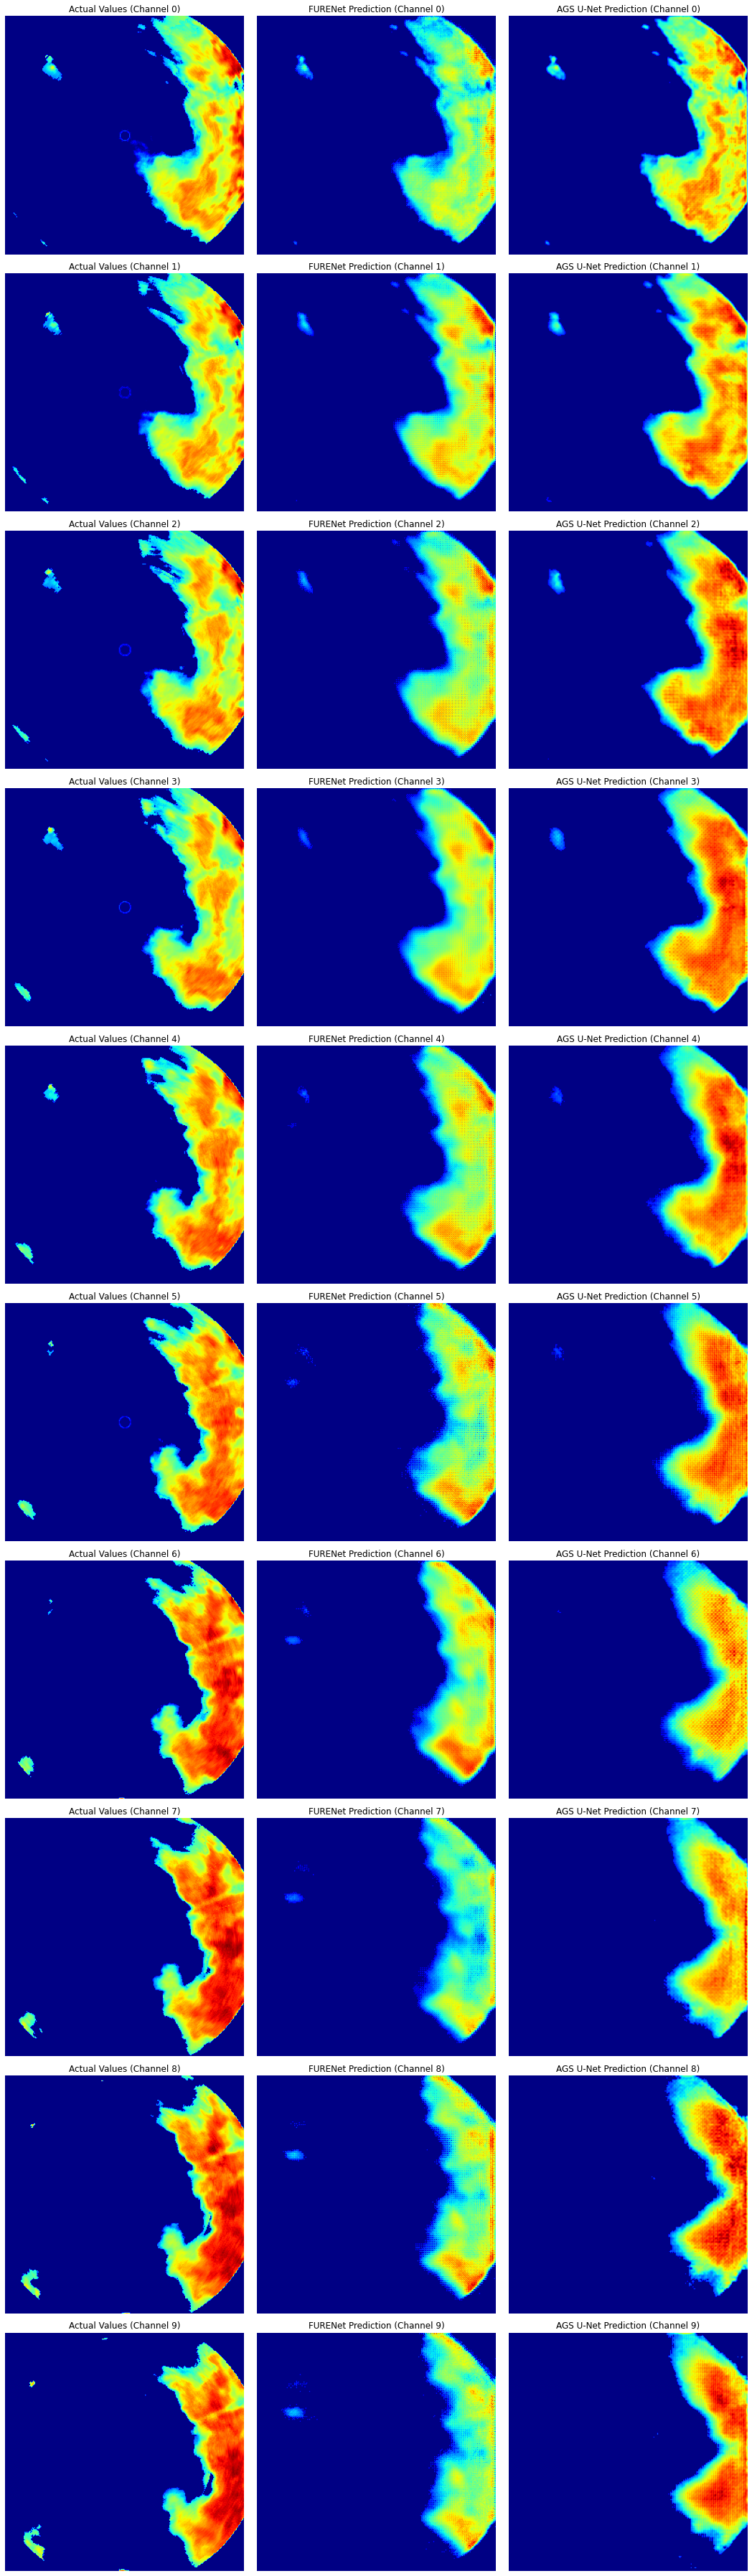

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

# 创建自定义颜色映射
colors = [(cm.jet(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
ground_truth_sample = ground_truth[sample_idx]
FURENet_sample = FURENet_prediction[sample_idx]
FURENet_Meta_sample = FURENet_Meta_prediction[sample_idx]

# 获取通道/时间步的数量
num_channels = ground_truth_sample.shape[0]

# 定义要显示的行
# display_rows = [1, 3, 5, 7, 9]  # 对应于第2、4、6、8和10行
display_rows = [0,1,2,3,4,5,6,7,8,9]

# 创建一个新的figure对象
fig = plt.figure(figsize=(15, 5 * len(display_rows)))  # 调整figure大小以适应三列

for i, channel_idx in enumerate(display_rows):
    ground_truth_channel = ground_truth_sample[channel_idx]
    FURENet_channel = FURENet_sample[channel_idx]
    FURENet_Meta_channel = FURENet_Meta_sample[channel_idx]
    
    # 为真实值创建子图
    ax_gt = fig.add_subplot(len(display_rows), 3, i*3 + 1)  # 修改为3列布局
    ax_gt.imshow(ground_truth_channel, cmap=new_map, origin='upper')
    ax_gt.set_title(f'Actual Values (Channel {channel_idx})')
    ax_gt.axis('off')
    
    # 为FURENet预测值创建子图
    ax_furenet = fig.add_subplot(len(display_rows), 3, i*3 + 2)  # 修改为3列布局
    ax_furenet.imshow(FURENet_channel, cmap=new_map, origin='upper')
    ax_furenet.set_title(f'FURENet Prediction (Channel {channel_idx})')
    ax_furenet.axis('off')

    # 为AGS U-Net预测值创建子图（假设为FURENet_Meta_prediction）
    ax_agsunet = fig.add_subplot(len(display_rows), 3, i*3 + 3)  # 修改为3列布局
    ax_agsunet.imshow(FURENet_Meta_channel, cmap=new_map, origin='upper')
    ax_agsunet.set_title(f'AGS U-Net Prediction (Channel {channel_idx})')
    ax_agsunet.axis('off')

# 调整子图之间的间距
plt.tight_layout()
plt.show()


In [39]:
def denormalize(tensor, norm_param):
    mmin, mmax = norm_param
    denormalized_tensor = tensor * (mmax - mmin) + mmin
    return denormalized_tensor

In [40]:
def calculate_csi(ground_truth, prediction, norm_param, threshold=30):
    # 反归一化
    ground_truth_denorm = denormalize(ground_truth, norm_param)
    prediction_denorm = denormalize(prediction, norm_param)
    
    # 将张量转换为numpy数组
    ground_truth_np = ground_truth_denorm.cpu().numpy()
    prediction_np = prediction_denorm.cpu().numpy()
    
    # 将数据转换为二进制
    ground_truth_bin = (ground_truth_np >= threshold).astype(float)
    prediction_bin = (prediction_np >= threshold).astype(float)
    
    # 计算 Hits, Misses, 和 False Alarms
    hits = np.sum(ground_truth_bin * prediction_bin)
    misses = np.sum(ground_truth_bin * (1 - prediction_bin))
    false_alarms = np.sum((1 - ground_truth_bin) * prediction_bin)
    
    # 计算 CSI
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) != 0 else 0
    return csi

In [45]:
norm_param_dbz = [0, 65]
calculate_csi(ground_truth, FURENet_Meta_prediction, norm_param_dbz)

0.40664618769699323

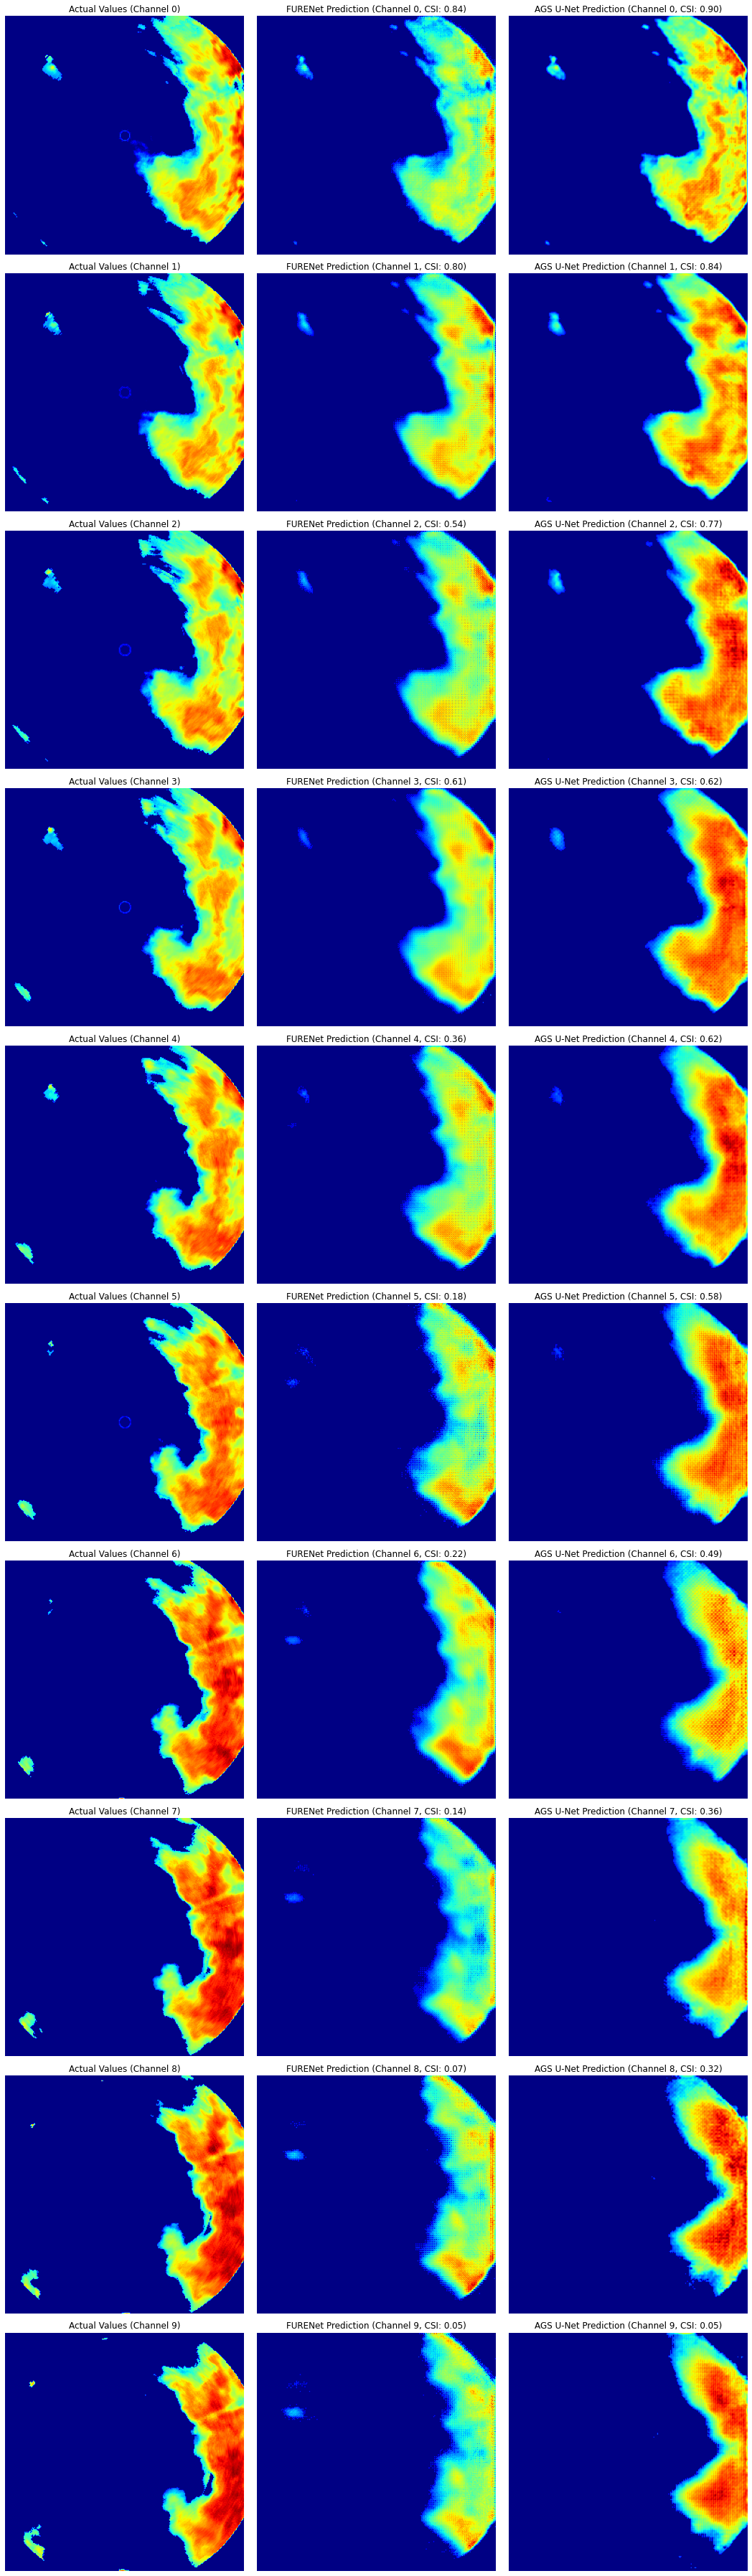

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

# 创建自定义颜色映射
colors = [(cm.jet(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
ground_truth_sample = ground_truth[sample_idx]
FURENet_sample = FURENet_prediction[sample_idx]
FURENet_Meta_sample = FURENet_Meta_prediction[sample_idx]

# 获取通道/时间步的数量
num_channels = ground_truth_sample.shape[0]

# 定义要显示的行
# display_rows = [1, 3, 5, 7, 9]  # 对应于第2、4、6、8和10行
display_rows = [0,1,2,3,4,5,6,7,8,9]

# 创建一个新的figure对象
fig = plt.figure(figsize=(15, 5 * len(display_rows)))  # 调整figure大小以适应三列

for i, channel_idx in enumerate(display_rows):
    ground_truth_channel = ground_truth_sample[channel_idx]
    FURENet_channel = FURENet_sample[channel_idx]
    FURENet_Meta_channel = FURENet_Meta_sample[channel_idx]
    
    # 计算每个通道的CSI值
    csi_furenet = calculate_csi(ground_truth_channel, FURENet_channel, norm_param_dbz)
    csi_furenet_meta = calculate_csi(ground_truth_channel, FURENet_Meta_channel, norm_param_dbz)

    # 为真实值创建子图
    ax_gt = fig.add_subplot(len(display_rows), 3, i*3 + 1)  # 修改为3列布局
    ax_gt.imshow(ground_truth_channel, cmap=new_map, origin='upper')
    ax_gt.set_title(f'Actual Values (Channel {channel_idx})')
    ax_gt.axis('off')
    
    # 为FURENet预测值创建子图
    ax_furenet = fig.add_subplot(len(display_rows), 3, i*3 + 2)  # 修改为3列布局
    ax_furenet.imshow(FURENet_channel, cmap=new_map, origin='upper')
    ax_furenet.set_title(f'FURENet Prediction (Channel {channel_idx}, CSI: {csi_furenet:.2f})')
    ax_furenet.axis('off')

    # 为AGS U-Net预测值创建子图（假设为FURENet_Meta_prediction）
    ax_agsunet = fig.add_subplot(len(display_rows), 3, i*3 + 3)  # 修改为3列布局
    ax_agsunet.imshow(FURENet_Meta_channel, cmap=new_map, origin='upper')
    ax_agsunet.set_title(f'AGS U-Net Prediction (Channel {channel_idx}, CSI: {csi_furenet_meta:.2f})')
    ax_agsunet.axis('off')

# 调整子图之间的间距
plt.tight_layout()
plt.show()


In [48]:
import os

# 确保输出目录存在
output_dir = '/root/autodl-tmp/competition/output_pic'
os.makedirs(output_dir, exist_ok=True)

for sample_idx in range(10,20):  # 循环从0到9
    ground_truth_sample = ground_truth[sample_idx]
    FURENet_sample = FURENet_prediction[sample_idx]
    FURENet_Meta_sample = FURENet_Meta_prediction[sample_idx]

    # 创建一个新的figure对象
    fig = plt.figure(figsize=(15, 5 * len(display_rows)))  # 调整figure大小以适应三列

    for i, channel_idx in enumerate(display_rows):
        ground_truth_channel = ground_truth_sample[channel_idx]
        FURENet_channel = FURENet_sample[channel_idx]
        FURENet_Meta_channel = FURENet_Meta_sample[channel_idx]

        # 计算每个通道的CSI值
        csi_furenet = calculate_csi(ground_truth_channel, FURENet_channel, norm_param_dbz)
        csi_furenet_meta = calculate_csi(ground_truth_channel, FURENet_Meta_channel, norm_param_dbz)

        # 为真实值创建子图
        ax_gt = fig.add_subplot(len(display_rows), 3, i*3 + 1)  # 修改为3列布局
        ax_gt.imshow(ground_truth_channel, cmap=new_map, origin='upper')
        ax_gt.set_title(f'Actual Values (Channel {channel_idx})')
        ax_gt.axis('off')
        
        # 为FURENet预测值创建子图
        ax_furenet = fig.add_subplot(len(display_rows), 3, i*3 + 2)  # 修改为3列布局
        ax_furenet.imshow(FURENet_channel, cmap=new_map, origin='upper')
        ax_furenet.set_title(f'FURENet Prediction (Channel {channel_idx}, CSI: {csi_furenet:.2f})')
        ax_furenet.axis('off')

        # 为AGS U-Net预测值创建子图（假设为FURENet_Meta_prediction）
        ax_agsunet = fig.add_subplot(len(display_rows), 3, i*3 + 3)  # 修改为3列布局
        ax_agsunet.imshow(FURENet_Meta_channel, cmap=new_map, origin='upper')
        ax_agsunet.set_title(f'AGS U-Net Prediction (Channel {channel_idx}, CSI: {csi_furenet_meta:.2f})')
        ax_agsunet.axis('off')

    # 调整子图之间的间距
    plt.tight_layout()

    # 保存图像
    output_path = os.path.join(output_dir, f'sample_{sample_idx}.png')
    plt.savefig(output_path)
    plt.close(fig)  # 关闭图像，以释放内存

    print(f'Saved image for sample {sample_idx} to {output_path}')


Saved image for sample 10 to /root/autodl-tmp/competition/output_pic/sample_10.png
Saved image for sample 11 to /root/autodl-tmp/competition/output_pic/sample_11.png
Saved image for sample 12 to /root/autodl-tmp/competition/output_pic/sample_12.png
Saved image for sample 13 to /root/autodl-tmp/competition/output_pic/sample_13.png
Saved image for sample 14 to /root/autodl-tmp/competition/output_pic/sample_14.png
Saved image for sample 15 to /root/autodl-tmp/competition/output_pic/sample_15.png
Saved image for sample 16 to /root/autodl-tmp/competition/output_pic/sample_16.png
Saved image for sample 17 to /root/autodl-tmp/competition/output_pic/sample_17.png
Saved image for sample 18 to /root/autodl-tmp/competition/output_pic/sample_18.png
Saved image for sample 19 to /root/autodl-tmp/competition/output_pic/sample_19.png
